In [147]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras import models
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load Data

In [148]:
paths = []
labels = []

# Use os.walk to walk through the directory structure
for dirname, _, filenames in os.walk(r'data'):
    for filename in filenames:
        if filename == '.DS_Store':
            continue  # Skip this file
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        paths.append(full_path)
        
        # Extract label and gender from the directory name
        # Assumes the structure is data/label_gender/filename
        folder_name = os.path.basename(dirname)
        label = folder_name
        label = label.split('_')[0]
        labels.append(label.lower())

# Create a DataFrame with the collected data
df = pd.DataFrame({
    'speech': paths,
    'label': labels,
})

# Display the first few rows of the DataFrame to verify
print(df.head())

                                  speech    label
0  data/Neutral_Female/jt_neutral_21.wav  neutral
1  data/Neutral_Female/ws_neutral_25.wav  neutral
2  data/Neutral_Female/ws_neutral_31.wav  neutral
3  data/Neutral_Female/ws_neutral_19.wav  neutral
4   data/Neutral_Female/neutral_xn_1.wav  neutral


In [149]:
# paths = []
# labels = []
# for _, folders, _ in os.walk(r'data'):
#     for folder in folders:
#         for dirname, _, filenames in os.walk(f'data\{folder}'):
#             for filename in filenames:
#                 paths.append(os.path.join(dirname, filename))
#                 label = folder
#                 label = label.split('_')[0] # remove to segregate by gender
#                 labels.append(label.lower())

# df = pd.DataFrame()
# df['speech'] = paths
# df['label'] = labels

# print('Dataset is Loaded')
# print(df.head())

# EDA

<Axes: >

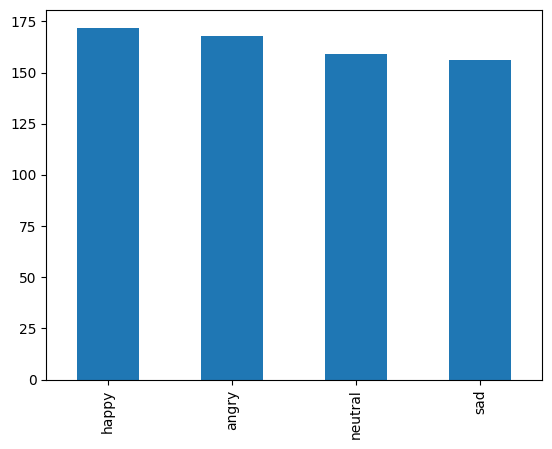

In [150]:
df['label'].value_counts().plot(kind='bar')

In [151]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

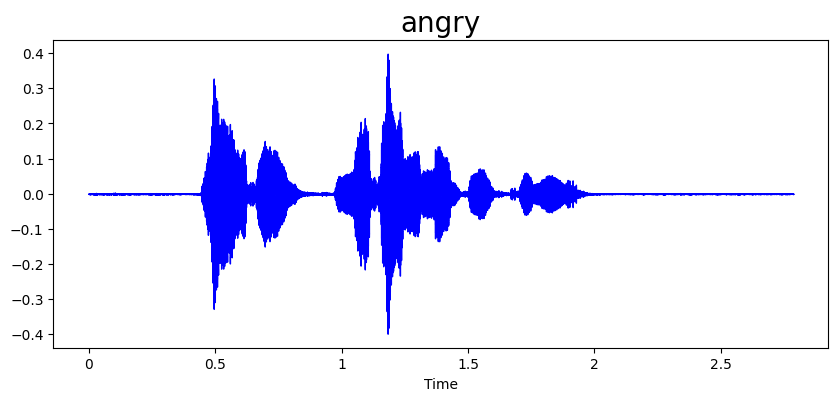

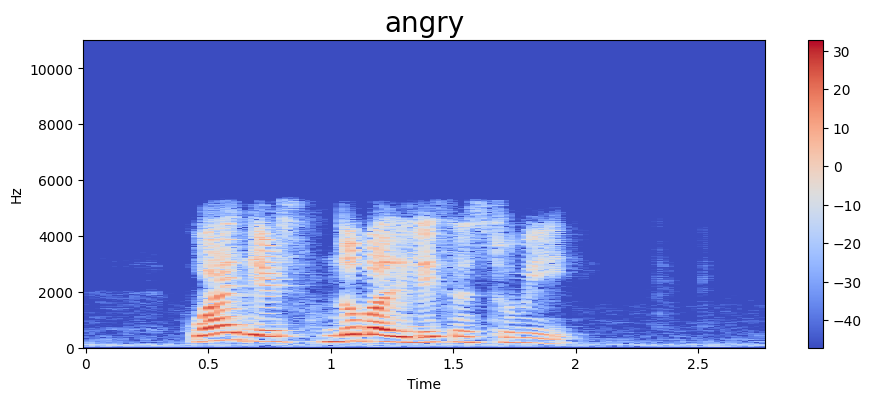

In [152]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[146]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# Feature Engineering

In [153]:
# from sklearn.preprocessing import OneHotEncoder

# def extract_mfcc(filename):
#     y, sr = librosa.load(filename, duration=3, offset=0.5)
#     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
#     return mfcc

# def processData(df):
#     X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
#     print(X_mfcc.head())
#     X = [x for x in X_mfcc]
#     X = np.array(X)
#     X = np.expand_dims(X, -1)
#     print(X.shape)

#     enc = OneHotEncoder()
#     y = enc.fit_transform(df[['label']])
#     y = y.toarray()
#     print(y.shape)
#     return X, y, enc

In [154]:
# X, y, enc = processData(df)

In [155]:
from sklearn.preprocessing import OneHotEncoder

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    # print(mfcc)
    return mfcc

def extract_chroma(filename):
    y, sr = librosa.load(filename)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    return chroma

def extract_spectral_contrast(filename):
    y, sr = librosa.load(filename)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    return contrast

def extract_tonnetz(filename):
    y, sr = librosa.load(filename)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
    return tonnetz

def processData(df):
    # mfcc
    mfcc_columns = ['mfcc_' + str(i) for i in range(1, 41)]
    mfcc_df = pd.DataFrame(df['speech'].apply(lambda x: extract_mfcc(x)).tolist(), columns=mfcc_columns)
    new_df = pd.concat([df, mfcc_df], axis=1)

    # chroma 
    chroma_columns = ['chroma_' + str(i) for i in range(1, 13)]
    chroma_df = pd.DataFrame(df['speech'].apply(lambda x: extract_chroma(x)).tolist(), columns=chroma_columns)
    new_df = pd.concat([new_df, chroma_df], axis=1)

    # spectral_contrast
    spectral_columns = ['spectral_' + str(i) for i in range(1, 8)]
    spectral_df = pd.DataFrame(df['speech'].apply(lambda x: extract_spectral_contrast(x)).tolist(), columns=spectral_columns)
    new_df = pd.concat([new_df, spectral_df], axis=1)

    # tonnetz
    tonnetz_columns = ['tonnetz_' + str(i) for i in range(1, 8)]
    tonnetz_df = pd.DataFrame(df['speech'].apply(lambda x: extract_spectral_contrast(x)).tolist(), columns=tonnetz_columns)
    new_df = pd.concat([new_df, tonnetz_df], axis=1)

    return new_df

data = processData(df)

correlation_matrix = data[data.columns[2:]].corr()
pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if correlation_matrix.iloc[i, j] > 0.75 or correlation_matrix.iloc[i, j] < -0.75:
            pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

high_corr_df = pd.DataFrame(pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_set = set(high_corr_df['Feature 2'])

dropped_data = data.drop(columns=[col for col in data.columns if col in high_corr_set])
dropped_data.head()

,speech,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_9,...,mfcc_34,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40,chroma_1,chroma_8,spectral_1,spectral_2
0,data/Neutral_Female/jt_neutral_21.wav,neutral,-353.485931,123.602257,-61.569126,39.862431,-27.980495,-24.715317,-0.133174,-2.212441,...,4.061761,3.313922,5.554673,-2.422093,-1.752038,0.314916,0.247846,0.645633,34.458182,14.673575
1,data/Neutral_Female/ws_neutral_25.wav,neutral,-564.134766,126.061310,-4.919215,37.116371,0.208729,9.160780,21.036594,23.856047,...,5.463705,0.146079,4.786485,-2.631112,0.266556,-0.360581,0.571912,0.627030,21.557366,16.469228
2,data/Neutral_Female/ws_neutral_31.wav,neutral,-539.205750,138.167038,-16.331873,54.644619,0.998931,10.805608,24.811714,24.078247,...,3.680650,2.151067,4.704717,-1.963487,4.114218,-0.956650,0.475850,0.465181,22.596028,15.552894
3,data/Neutral_Female/ws_neutral_19.wav,neutral,-492.109070,154.774780,-30.476576,45.752804,0.734304,3.639598,8.156684,20.397802,...,7.989627,-2.455146,4.810430,-5.106880,-0.704052,1.789229,0.439870,0.546113,18.194261,14.768661
4,data/Neutral_Female/neutral_xn_1.wav,neutral,-548.042175,143.709137,-27.734171,78.299103,-5.085223,-10.435101,6.878770,15.428833,...,-0.555660,-4.141469,2.441621,0.422122,4.424841,2.749235,0.471181,0.370252,30.322829,16.262694


In [156]:
def processData(df):
    X = df.drop(columns=["label", "speech"])
    X = np.expand_dims(X, -1)
    print(X.shape)

    enc = OneHotEncoder()
    y = enc.fit_transform(df[['label']])
    y = y.toarray()
    print(y.shape)
    return X, y, enc
X, y, enc = processData(dropped_data)

(655, 37, 1)
(655, 4)


# Model Training

In [157]:
from sklearn.model_selection import train_test_split

# Separate the test data
x_1, x_test, y_1, y_test = train_test_split(X, y, test_size=0.10, shuffle=True, random_state=42, stratify=y)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_1, y_1, test_size=0.15, shuffle=True, random_state=42, stratify=y_1)

In [158]:
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

model = models.Sequential()
model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(128, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=3, strides=1,
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 37, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 19, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 10, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,348 (1.04 MB)

 Trainable params: 273,348 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

# Model Evaluation

In [159]:
# Training the Keras model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - acc: 0.2497 - f1_m: 0.2403 - loss: 33.4429 - val_acc: 0.2584 - val_f1_m: 0.2528 - val_loss: 5.8413
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.2550 - f1_m: 0.2480 - loss: 5.6738 - val_acc: 0.2697 - val_f1_m: 0.2398 - val_loss: 1.7052
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.2697 - f1_m: 0.2475 - loss: 1.9514 - val_acc: 0.2584 - val_f1_m: 0.0000e+00 - val_loss: 1.4450
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.2711 - f1_m: 0.1212 - loss: 1.4948 - val_acc: 0.3371 - val_f1_m: 0.0385 - val_loss: 1.4091
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.3063 - f1_m: 0.0810 - loss: 1.4264 - val_acc: 0.2809 - val_f1_m: 0.2712 - val_loss: 1.5200
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.3359 - f1_m: 0.1404 - loss: 1.3819 - val_acc: 0.2584 - val_f1_m: 0.2460 - val_loss: 1.8154
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.2303 - f1_m: 0.2000 - loss: 2.0674 - val_ac

In [160]:
model.evaluate(x=x_test, y=y_test)
predictions = model.predict(x_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.7812 - f1_m: 0.7619 - loss: 0.5544

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.8535 - f1_m: 0.8571 - loss: 0.4178
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


----- F1 -----


0.879205659536542
----- AUC ROC -----
0.9730570978391356
----- AUC ROC Curve -----


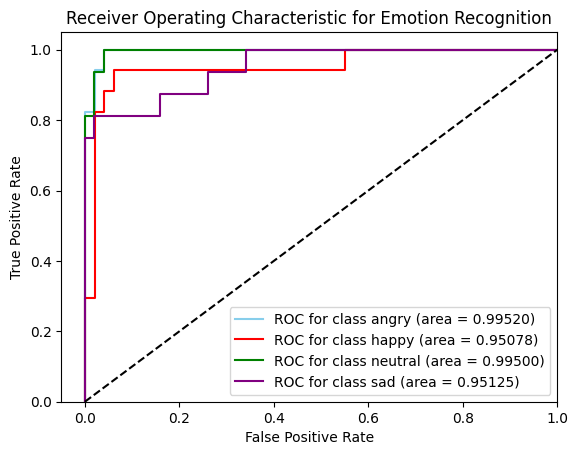

----- Confusion Matrix -----


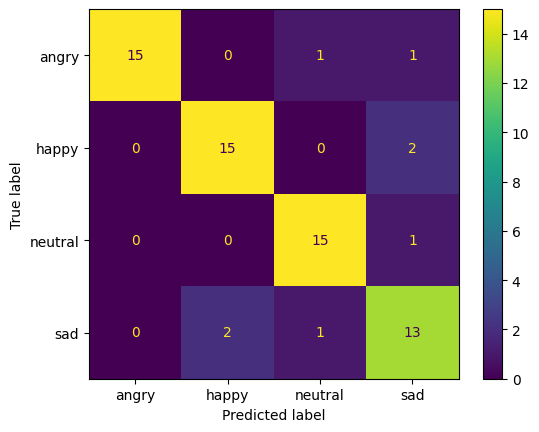

----- Classification Report -----
              precision    recall  f1-score   support

       angry       1.00      0.88      0.94        17
       happy       0.88      0.88      0.88        17
     neutral       0.88      0.94      0.91        16
         sad       0.76      0.81      0.79        16

    accuracy                           0.88        66
   macro avg       0.88      0.88      0.88        66
weighted avg       0.88      0.88      0.88        66



In [161]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_curve, 
    auc,
    roc_auc_score,
    f1_score
)

print("----- F1 -----")
print(f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average="macro"))

print("----- AUC ROC -----")
print(roc_auc_score(y_test, predictions, multi_class="ovr", labels=list(enc.categories_[0])))

print("----- AUC ROC Curve -----")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['skyblue', 'red', 'green', 'purple']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'ROC for class {list(enc.categories_[0])[i]} (area = {roc_auc[i]:.5f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Emotion Recognition')
plt.legend(loc="lower right")
plt.show()


print("----- Confusion Matrix -----")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(enc.categories_[0]))
disp.plot()
plt.show()

print("----- Classification Report -----")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names=list(enc.categories_[0])))


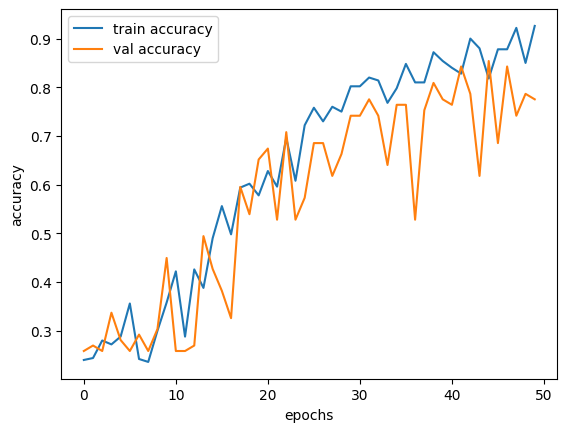

In [162]:
epochs = list(range(50))
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

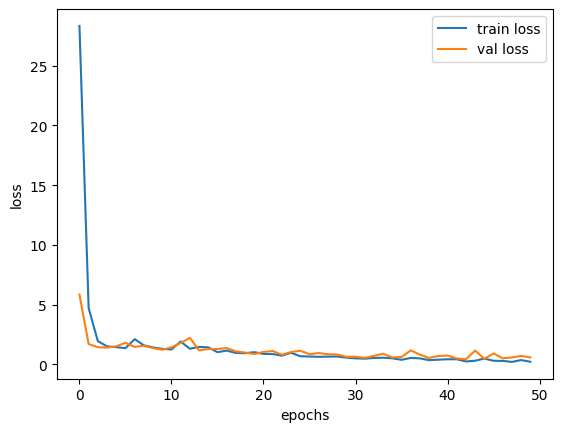

In [163]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()